In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import shutil
import tqdm

In [3]:
FAST_RUN = False
IMAGE_WIDTH=180
IMAGE_HEIGHT=180
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size = 16

# Mount directory (to be done if you don't see the directory "gdrive" on the "files" tab)

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Retrieving the data

In [6]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
# Base directory where the images were stored
base_data_path = '/content/gdrive/MyDrive/Opteeq-Task-A/Data'

# Get directories of each class
path_0 = os.path.join(base_data_path, 'Original/000')
path_90 = os.path.join(base_data_path, 'Original/090')
path_180 = os.path.join(base_data_path, 'Original/180')
path_270 = os.path.join(base_data_path, 'Original/270')

In [10]:
# Assign labels to filenames and store in pandas df 
directories = {"000": path_0, "090": path_90, "180": path_180, "270": path_270}

categories = [] 
images = []

for label in directories: 

  directory = directories[label]

  filenames = os.listdir(directory)

  for filename in filenames: 
    if label == "000": 
      l = 0
    elif label == "090":
      l = 1
    elif label == "180":
      l = 2 
    elif label == "270": 
      l = 3

    categories.append(l)
    images.append(filename)

df = pd.DataFrame({
  'filename': images,
  'category': categories
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3500 non-null   object
 1   category  3500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


In [11]:
df.head()

,filename,category
0,2015_the_walfare_state_vexhibition_view_photo_...,0
1,052315-national-crazy-restaurant-receipts-loui...,0
2,1197-receipt_000.jpg,0
3,121266073_3302898489831540_4499910750829741831...,0
4,2021-03-18._000.jpg,0


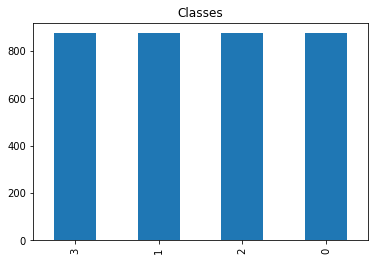

In [12]:
df['category'].value_counts().plot.bar(title="Classes")

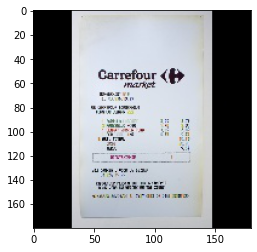

In [13]:
filename = df['filename'].values[0]

im_path = os.path.join(path_0, filename)

image = load_img(im_path)

plt.imshow(image)

# Train/Test split

In [ ]:
# Split data into train and validation data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
print(len(train_df))
print(len(val_df))

2800
700


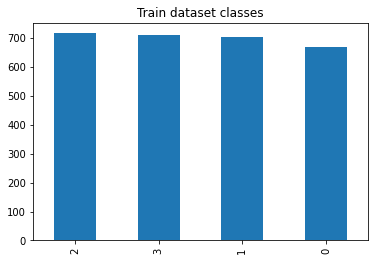

In [ ]:
train_df['category'].value_counts().plot.bar(title="Train dataset classes")

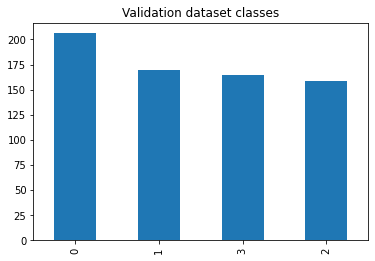

In [ ]:
val_df['category'].value_counts().plot.bar(title="Validation dataset classes")

# Build dataset

In [ ]:
dataset_name = "dataset_v2"

dataset_path = os.path.join(base_data_path, dataset_name)

# Build path to dataset directory
if not os.path.exists(dataset_path): 
  os.mkdir(dataset_path)

In [ ]:
from tqdm.notebook import tqdm_notebook
# Save dataset to gdrive in train and val directories with folder for each class
# Only need run once 

data = {"train": train_df, "val": val_df}

directories = {"0": path_0, "1": path_90, "2": path_180, "3": path_270}

# Loop through train/test/val and create a directory for each within 
# The dataset directory
# Make a copy of the dataframe for train/test/val and loop through rows
# Read in each image from the original location and write it to the new location
for key in tqdm_notebook(data, desc='Loop 1'): 

  out_path = os.path.join(dataset_path, key)

  if not os.path.exists(out_path): 
    os.mkdir(out_path)

  df = data[key].copy()

  for index, row in tqdm_notebook(df.iterrows(), desc='Loop 2'):
    
    filename = row[0]
    cat = row[1]

    in_path = directories[str(cat)]

    img = load_img(os.path.join(in_path, filename))
    
    save_img(os.path.join(out_path, filename), img)



Loop 1:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2: 0it [00:00, ?it/s]

Loop 2: 0it [00:00, ?it/s]

# Data generators

In [ ]:
train_df["category"] = train_df["category"].astype('string')

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    os.path.join(dataset_path, "train"), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2800 validated image filenames belonging to 4 classes.


In [ ]:
val_df["category"] = val_df["category"].astype('string')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    os.path.join(dataset_path, "val"), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 700 validated image filenames belonging to 4 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    os.path.join(dataset_path, "train"), 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


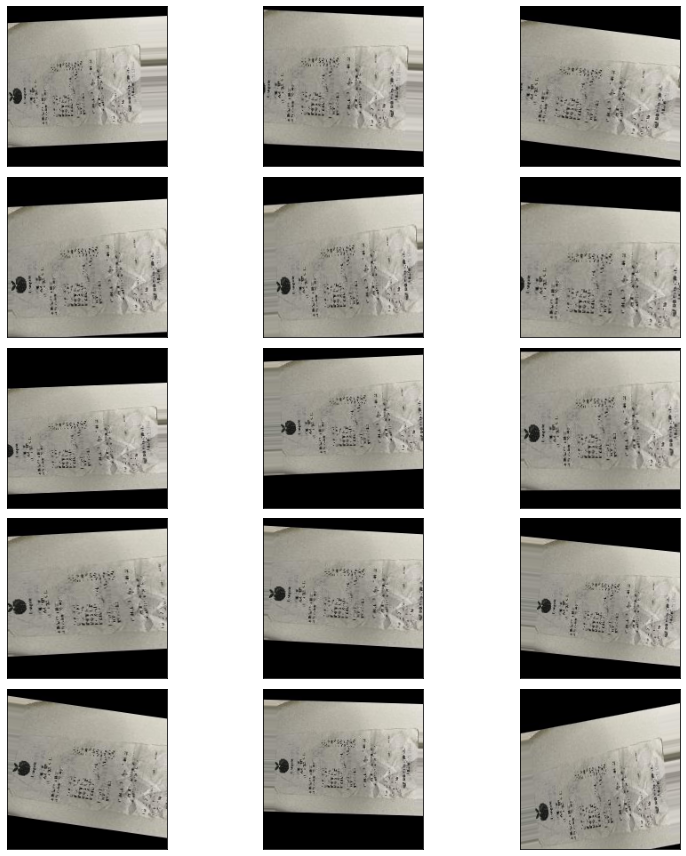

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False) 
        break
plt.tight_layout()
plt.show()

# Build model

In [ ]:
import time

model_name = "VGG16"

timestamp = time.strftime("%Y%m%d-%H%M%S")

folder_name = model_name + "-" + timestamp

base_experiments_path = '/content/gdrive/MyDrive/Opteeq-Task-A/Experiments'

experiment_path = os.path.join(base_experiments_path, model_name)

model_path = os.path.join(experiment_path, folder_name)

if not os.path.exists(model_path):
  os.mkdir(model_path)
          

In [ ]:
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


image_size = IMAGE_SIZE
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

epochs = 20

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Stochastic gradient decent optimizer
optimizer = 'sgd'

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint(os.path.join(model_path,'{}_best_model_{}.h5'.format(model_name, timestamp)), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0   

# Model training

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (16, 180, 180, 3)
labels batch shape: (16, 4)


In [ ]:
total_train = len(train_df)
total_val = len(val_df)

In [ ]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[es, mc])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
175/175 [==============================] - 40s 226ms/step - loss: 0.6768 - accuracy: 0.6911 - val_loss: 0.5081 - val_accuracy: 0.7674

Epoch 00001: val_accuracy improved from -inf to 0.76744, saving model to /content/gdrive/MyDrive/Opteeq-Task-A/Experiments/VGG16/VGG16-20210907-101331/VGG16_best_model_20210907-101331.h5
Epoch 2/20
175/175 [==============================] - 39s 225ms/step - loss: 0.2799 - accuracy: 0.8907 - val_loss: 0.1305 - val_accuracy: 0.9477

Epoch 00002: val_accuracy improved from 0.76744 to 0.94767, saving model to /content/gdrive/MyDrive/Opteeq-Task-A/Experiments/VGG16/VGG16-20210907-101331/VGG16_best_model_20210907-101331.h5
Epoch 3/20
175/175 [==============================] - 39s 224ms/step - loss: 0.1712 - accuracy: 0.9407 - val_loss: 0.0978 - val_accuracy: 0.9637

Epoch 00003: val_accuracy improved from 0.94767 to 0.96366, saving model to /content/gdrive/MyDrive/Opteeq-Task-A/Experiments/VGG16/VGG16-20210907-101331/VGG16_best_model_20210907-10133

# Visualise training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


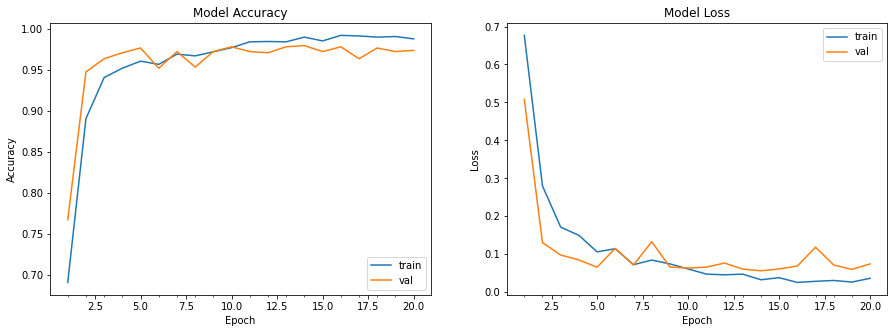

In [ ]:
eval_path = os.path.join(model_path, "evaluation_report")

if not os.path.exists(eval_path):
  os.mkdir(eval_path)    

def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig(os.path.join(eval_path, "model_history.png"))
    plt.show()


plot_model_history(history)


<Figure size 432x288 with 0 Axes>

# Load in a model for evaluation

In [18]:
from keras.models import load_model

model_path = "/content/gdrive/MyDrive/Opteeq-Task-A/Experiments/VGG16/VGG16-20210907-101331"

files = os.listdir(model_path)

for file in files: 
  if file.endswith(".h5"):
    model = load_model(os.path.join(model_path, file))

# Model evaluation

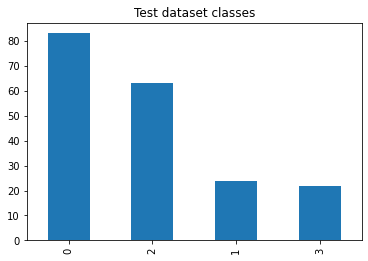

In [77]:
#Datasets Preparation
in_dir = "/content/gdrive/MyDrive/Opteeq-Task-A/Data/test_data"

test_dir = os.path.join(in_dir, "test")

if not os.path.exists(test_dir):
  os.mkdir(test_dir)

classes = ['000', '090', '180', '270']

categories = []
filenames = []

for c in classes: 
  path = os.path.join(in_dir, c)
  files = os.listdir(path)

  for filename in files:
    if c == '000':
      categories.append('0')
    elif c =='090':
      categories.append('1')
    elif c == '180':
      categories.append('2')
    elif c == '270':
      categories.append('3')

    filename_split = filename.split(".")

    filename_new = filename_split[0] + "." + c + "." + filename_split[1]

    img = load_img(os.path.join(path, filename))
    
    save_img(os.path.join(test_dir, filename_new), img)

    filenames.append(filename_new)

# DataFrame with all files and their class
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
    })

# Check the number of files of each class
test_df['category'].value_counts().plot.bar(title='Test dataset classes')
plt.show()

In [78]:
test_df.head()

,filename,category
0,IMG_1014.000.jpg,0
1,IMG_1001.000.JPG,0
2,IMG_1015.000.JPG,0
3,IMG_20210629_201357.000.jpg,0
4,IMG_20210629_200507.000.jpg,0


In [79]:
test_df["category"] = test_df["category"].astype('string')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

Found 192 validated image filenames belonging to 4 classes.


In [80]:
# Let's see the test performance of the network
test_loss, test_acc = model.evaluate_generator(test_generator, steps=34)
print('test acc:', test_acc)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9895833134651184


## Confusion Matrix

In [81]:
from sklearn.preprocessing import LabelBinarizer

# Get predictions using predict_generator
y_test = test_df["category"].astype(int)
y_pred = model.predict_generator(test_generator)

# Set threshold
threshold = 0.5

#
y_final = np.where(y_pred > threshold, 1, 0).argmax(axis=1)
test_df['pred'] = y_final

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


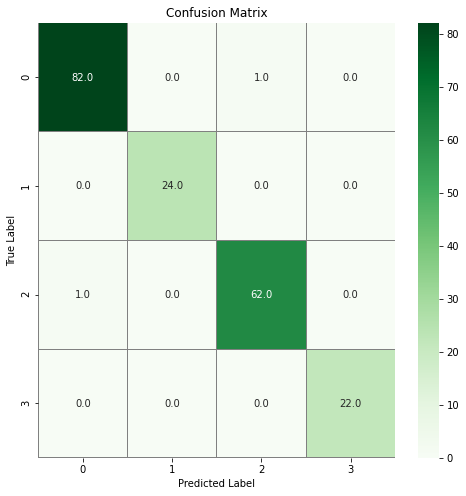

In [82]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

eval_path = os.path.join(model_path, "evaluation_report")

if not os.path.exists(eval_path):
  os.mkdir(eval_path) 

# compute the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(eval_path, "confusion_matrix.png"))
plt.show()

# Classification report

In [83]:
from sklearn.metrics import classification_report
import pandas as pd

eval_path = os.path.join(model_path, "evaluation_report")

if not os.path.exists(eval_path):
  os.mkdir(eval_path) 

# Generate a classification report
report = classification_report(y_test, y_final, target_names=['0', '90', '180', '270'])
# Generate a classification report
report_dict = classification_report(y_test, y_final, target_names=['0', '90', '180', '270'], output_dict=True)
report_df = pd.DataFrame.from_dict(report_dict)
report_df.to_csv(os.path.join(eval_path, "classification_report.csv"))
print(report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99        83
          90       1.00      1.00      1.00        24
         180       0.98      0.98      0.98        63
         270       1.00      1.00      1.00        22

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



# View predictions

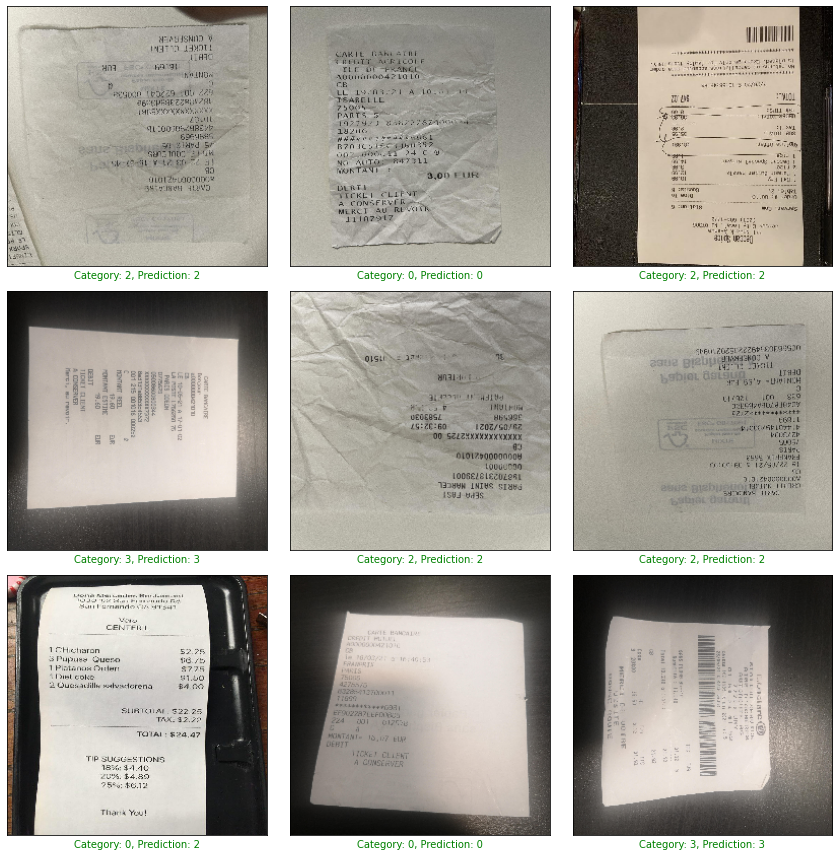

In [88]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")

sample_preds_path = os.path.join(model_path, "sample_predictions")

if not os.path.exists(sample_preds_path):
  os.mkdir(sample_preds_path)

sample_test = test_df.sample(n=9).reset_index()

fig = plt.figure(figsize=(12,12))

for i, row in sample_test.iterrows():
      i+=1
      
      col = 'red' if row['pred'] == row['category'] else 'green'

      img = load_img(os.path.join(test_dir, row['filename']), target_size=(256, 256))
      
      ax = fig.add_subplot(3, 3, i)
      ax.xaxis.label.set_color(col) 
      ax.imshow(img)
      ax.set_xlabel("Category: {}, Prediction: {}".format(int(row['category']), row['pred']))
      ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False) 
    

plt.tight_layout()
plt.savefig(os.path.join(sample_preds_path, "example_preds_{}.png".format(timestamp)))
plt.show()

# View prediction errors

In [84]:
errors = {}

for i, row in test_df.iterrows(): 
  if int(row['category']) != row['pred']:
    errors.update({i: row})
  else: 
    pass

errors_df = pd.DataFrame.from_dict(errors).transpose().reset_index(drop=True)

errors_df 


,filename,category,pred
0,Leo_26.000.jpg,0,2
1,IMG_0985.180.JPG,2,0


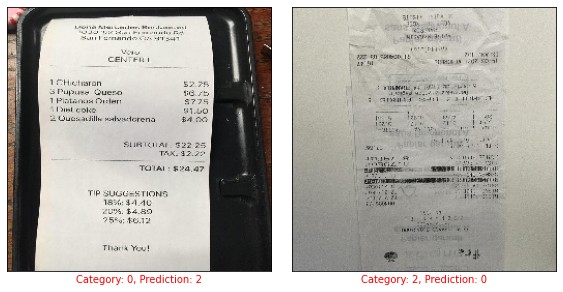

In [86]:
fig = plt.figure(figsize=(12,12))

for i, row in errors_df.iterrows():
      i+=1
      
      col = 'green' if row['pred'] == row['category'] else 'red'

      img = load_img(os.path.join(test_dir, row['filename']), target_size=(256, 256))
      
      ax = fig.add_subplot(3, 3, i)
      ax.xaxis.label.set_color(col) 
      ax.imshow(img)
      ax.set_xlabel("Category: {}, Prediction: {}".format(int(row['category']), row['pred']))
      ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False) 
    

plt.tight_layout()
plt.savefig(os.path.join(sample_preds_path, "example_errors_{}.png".format(timestamp)))
plt.show()

# Test prediction

In [ ]:
from keras.preprocessing.image import img_to_array

def predict_orientation(image_path: str, threshold: float) -> int:
    """Predicts and returns the orientation of a ticket image.
    Predicts 0 (good orientation) by default except if the model detects another orientation with
    a probability superior to the threshold given as parameter.

    :param image_path: path to the image
    :type image_path: str
    :param threshold: threshold between 0-1
    :type threshold: float
    :return: orientation prediction (0, 90, 180 or 270)
    :rtype: int
    """

    label_map = {0: 0, 1: 90, 2: 180, 3: 270}

    img = load_img(image_path, target_size=(180, 180))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    # Remember that the model was trained on inputs
    # that were preprocessed in the following way:
    img_tensor /= 255.
    
    prediction_prob = model.predict(img_tensor)
    if prediction_prob.max() > threshold:
         prediction = prediction_prob.argmax()
    else:
      print('Cunt')
    #    prediction = 0

    result = label_map[prediction]

    return img, result

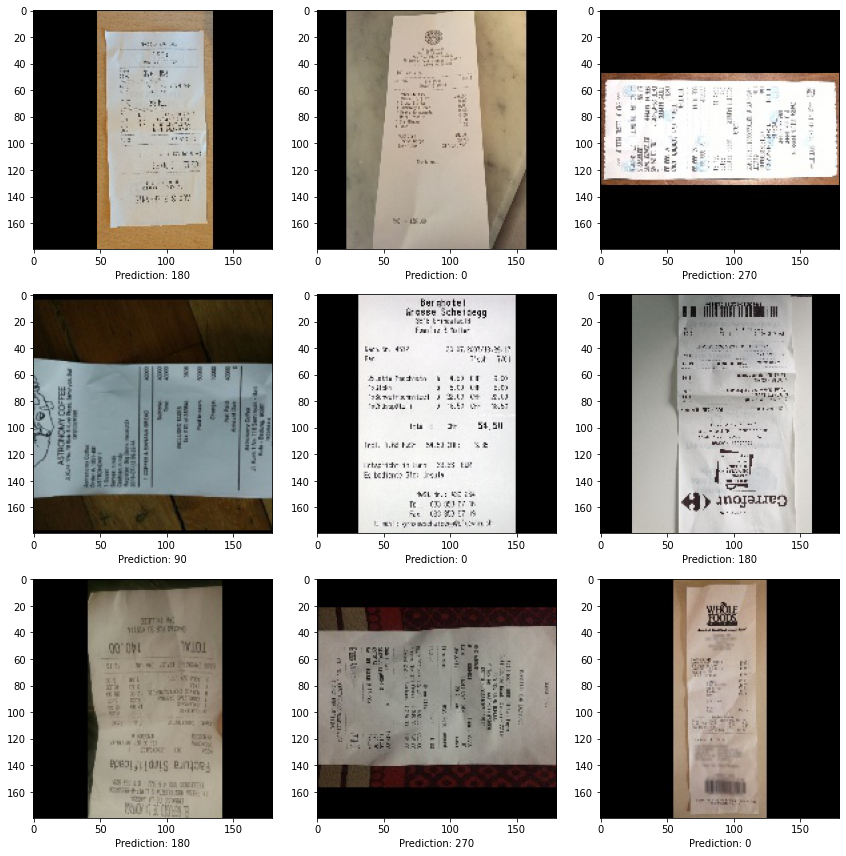

In [ ]:
test_path = os.path.join(base_data_path, "test")

test_1_df = pd.DataFrame({"filename": os.listdir(test_path)})

sample_test = test_1_df.sample(n=9).reset_index()

plt.figure(figsize=(12, 12))

for index, row in sample_test.iterrows():
    filename = row['filename']
    img, pred = predict_orientation(os.path.join(test_path, filename), 0.5)
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel("Prediction: {}".format(pred))
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False) 
    
plt.tight_layout()
plt.show()

    